In [191]:
import COVID19Py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
from datetime import datetime
from datetime import timedelta  

In [192]:
covid19 = COVID19Py.COVID19()

In [193]:
latest = covid19.getLatest()

In [213]:
def normatize_cases_by_absolute_day(df):
    
    days = []
    cases = []
    dates = []
    deaths = []
    recovereds = []
    contagious = []
    current_day = 0
    
    for i in range(df.shape[0]):
        if df.iloc[i].Cases > 0:
            current_day = current_day+1
            days.append(current_day)
            cases.append(df.iloc[i].Cases)
            datetime_object = datetime.strptime(str(df.iloc[i].Date), '%Y-%m-%dT%H:%M:%SZ')
            dates.append(datetime_object)
            deaths.append(df.iloc[i].Deaths)
            recovereds.append(df.iloc[i].Recovered)
            contagious.append(df.iloc[i].Contagious)
    df = pd.DataFrame({"Date":dates, "Day":days, "Cases": cases, "Deaths": deaths, "Recovered": recovereds, "Contagious": contagious})
    return df

def contagious_dataframe(df):
    contagious_list = []
    for x in range(df.shape[0]):
        if x == 0:
            contagious_list.append(0)
        if (x+1) < df.shape[0]:
            cases_sub = df.iloc[(x+1)].Cases - df.iloc[x].Cases
            contagious_list.append(cases_sub)
    df = pd.DataFrame({'Contagious': contagious_list})
    return df 

def data_consolidation(data):
    
    confirmed_dict = {}
    deaths_dict = {}
    recovered_dict = {}
    
    for i in range(len(data)):
        confirmed = data[i]['timelines']['confirmed']['timeline']
        deaths = data[i]['timelines']['deaths']['timeline']
        recovered = data[i]['timelines']['recovered']['timeline']
        for key in confirmed:
            if i == 0:
                confirmed_dict[key] = confirmed[key]
            else:
                confirmed_dict[key] = confirmed_dict[key]+confirmed[key]
        for key in deaths:
            if i == 0:
                deaths_dict[key] = deaths[key]
            else:
                deaths_dict[key] = deaths_dict[key]+deaths[key]
        for key in recovered:
            if i == 0:
                recovered_dict[key] = recovered[key]
            else:
                recovered_dict[key] = recovered_dict[key]+recovered[key]
                
    return confirmed_dict, deaths_dict, recovered_dict
            

In [214]:
no_catalog_cases_china = pd.read_csv(r'china_no_catalog_cases.csv', delimiter=";", header=None)
no_catalog_cases_china.columns = ['Date', 'Cases']

no_catalog_cases_china_deaths_recovered = pd.read_csv(r'china_no_catalog_cases_deaths_recovered.csv', delimiter=";", header=None)
no_catalog_cases_china_deaths_recovered.columns = ['Date', 'Cases']

In [219]:
brazil_confirmed_dict, brazil_deaths_dict, brazil_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("BR", timelines=True))
japan_confirmed_dict, japan_deaths_dict, japan_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("JP", timelines=True))
china_confirmed_dict, china_deaths_dict, china_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("CN", timelines=True))
south_korea_confirmed_dict, south_korea_deaths_dict, south_korea_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("KR", timelines=True))
italy_confirmed_dict, italy_deaths_dict, italy_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("IT", timelines=True))



dfBrazilConfirmedRaw = pd.DataFrame(brazil_confirmed_dict.items(), columns=['Date', 'Cases'])
dfJapanConfirmedRaw = pd.DataFrame(japan_confirmed_dict.items(), columns=['Date', 'Cases'])
dfChinaConfirmedRaw = pd.DataFrame(china_confirmed_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaConfirmedRaw = pd.DataFrame(south_korea_confirmed_dict.items(), columns=['Date', 'Cases'])
dfItalyConfirmedRaw = pd.DataFrame(italy_confirmed_dict.items(), columns=['Date', 'Cases'])

dfBrazilDeathsRaw = pd.DataFrame(brazil_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfJapanDeathsRaw = pd.DataFrame(japan_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfChinaDeathsRaw = pd.DataFrame(china_deaths_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaDeathsRaw = pd.DataFrame(south_korea_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfItalyDeathsRaw = pd.DataFrame(italy_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)

dfBrazilRecoveredRaw = pd.DataFrame(brazil_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfJapanRecoveredRaw = pd.DataFrame(japan_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfChinaRecoveredRaw = pd.DataFrame(china_recovered_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaRecoveredRaw = pd.DataFrame(south_korea_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfItalyRecoveredRaw = pd.DataFrame(italy_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)


dfChinaConfirmedRaw = pd.concat([no_catalog_cases_china, dfChinaConfirmedRaw], ignore_index=True)
dfChinaDeathsRaw = pd.concat([no_catalog_cases_china_deaths_recovered, dfChinaDeathsRaw], ignore_index=True).drop(["Date"], axis=1)
dfChinaRecoveredRaw = pd.concat([no_catalog_cases_china_deaths_recovered, dfChinaRecoveredRaw], ignore_index=True).drop(["Date"], axis=1)


dfBrazilContagiousRaw = contagious_dataframe(dfBrazilConfirmedRaw)
dfJapanContagiousRaw = contagious_dataframe(dfJapanConfirmedRaw)
dfChinaContagiousRaw = contagious_dataframe(dfChinaConfirmedRaw)
dfSouthKoreaContagiousRaw = contagious_dataframe(dfSouthKoreaConfirmedRaw)
dfItalyContagiousRaw = contagious_dataframe(dfItalyConfirmedRaw)

In [229]:
dfBrazilRaw = pd.concat(
    [dfBrazilConfirmedRaw,dfBrazilDeathsRaw, dfBrazilRecoveredRaw, dfBrazilContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfJapanRaw = pd.concat(
    [dfJapanConfirmedRaw,dfJapanDeathsRaw, dfJapanRecoveredRaw, dfJapanContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfChinaRaw = pd.concat(
    [dfChinaConfirmedRaw,dfChinaDeathsRaw, dfChinaRecoveredRaw, dfChinaContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfSouthKoreaRaw = pd.concat(
    [dfSouthKoreaConfirmedRaw,dfSouthKoreaDeathsRaw, dfSouthKoreaRecoveredRaw, dfSouthKoreaContagiousRaw], 
    ignore_index=True, 
    axis=1
)

dfItalyRaw = pd.concat(
    [dfItalyConfirmedRaw,dfItalyDeathsRaw, dfItalyRecoveredRaw, dfItalyContagiousRaw], 
    ignore_index=True, 
    axis=1
)


dfBrazilRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfJapanRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfChinaRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfSouthKoreaRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfItalyRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']


In [221]:
dfBrazil = normatize_cases_by_absolute_day(dfBrazilRaw)
dfJapan = normatize_cases_by_absolute_day(dfJapanRaw)
dfChina = normatize_cases_by_absolute_day(dfChinaRaw)
dfSouthKorea = normatize_cases_by_absolute_day(dfSouthKoreaRaw)
dfItaly = normatize_cases_by_absolute_day(dfItalyRaw)

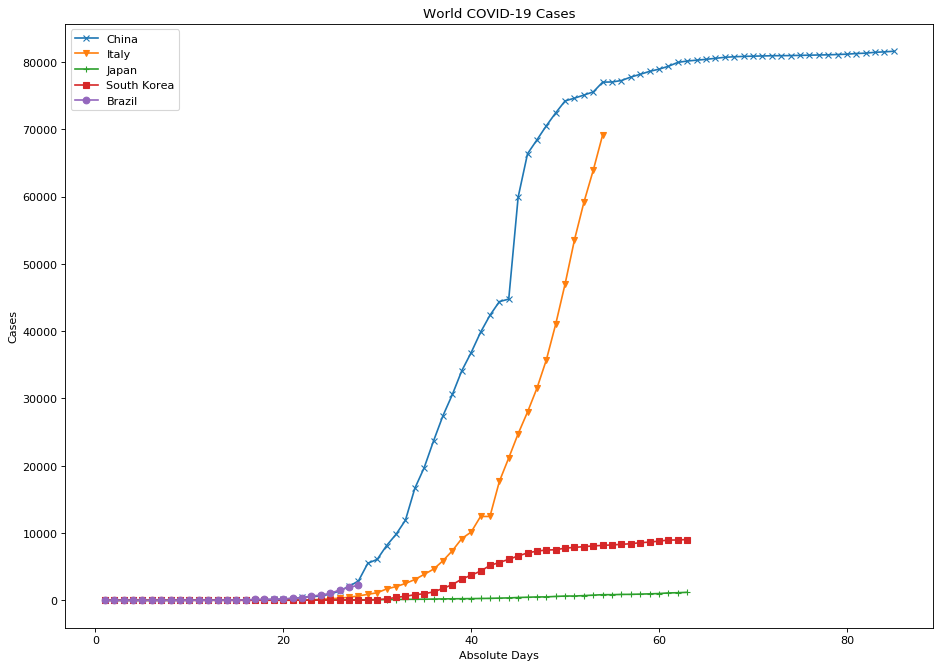

In [300]:
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfChina.Day, dfChina.Cases, "-x", label="China")
plt.plot(dfItaly.Day, dfItaly.Cases, "-v", label="Italy")
plt.plot(dfJapan.Day, dfJapan.Cases, "-+", label="Japan")
plt.plot(dfSouthKorea.Day, dfSouthKorea.Cases, "-s", label="South Korea")
plt.plot(dfBrazil.Day, dfBrazil.Cases, "-o", label="Brazil")
plt.title("World COVID-19 Cases")
plt.xlabel("Absolute Days")
plt.ylabel("Cases")
plt.legend(loc="upper left")
plt.show()

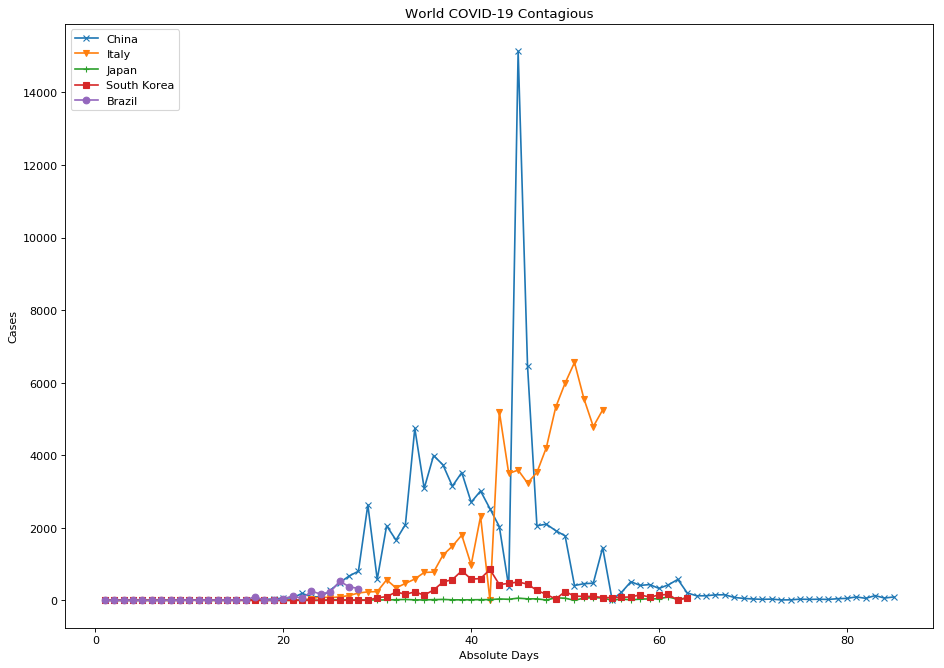

In [302]:
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfChina.Day, dfChina.Contagious, "-x", label="China")
plt.plot(dfItaly.Day, dfItaly.Contagious, "-v", label="Italy")
plt.plot(dfJapan.Day, dfJapan.Contagious, "-+", label="Japan")
plt.plot(dfSouthKorea.Day, dfSouthKorea.Contagious, "-s", label="South Korea")
plt.plot(dfBrazil.Day, dfBrazil.Contagious, "-o", label="Brazil")
plt.title("World COVID-19 Contagious")
plt.xlabel("Absolute Days")
plt.ylabel("Cases")
plt.legend(loc="upper left")
plt.show()

In [281]:
def calc_stable_day(df):
    df = contagious_dataframe(df)
    
    percentualContagious = []
    stable_final_day = None
    flag_break_stable_day = 0
    stable_final_day = None
    
    for x in range(df.shape[0]):
        percentual_day = (df.iloc[x].Contagious*100)/df.max().Contagious
        percentualContagious.append(percentual_day)
    
    
    for i in range(len(percentualContagious)):
        if int(percentualContagious[i]) == 100:
            flag_break_stable_day = flag_break_stable_day+1
        if flag_break_stable_day == 1 and int(percentualContagious[i]) == 0:
            flag_break_stable_day = flag_break_stable_day+1
        if flag_break_stable_day == 2:
            stable_final_day = i+1
            break
    
    
    return stable_final_day

In [282]:
days_to_stable_day = int(calc_stable_day(dfChina)+(calc_stable_day(dfChina)*0.3))

In [283]:
def normatization_for_stable_days(df, stable_total_days):
    days = []
    cases = []
    dates = []
    deaths = []
    recovereds = []
    contagious = []
    for i in range(stable_total_days):
        days.append(i+1)
        if i < df.shape[0]:
            cases.append(df.iloc[i].Cases)
            datetime_object = datetime.strptime(str(df.iloc[i].Date), '%Y-%m-%d %H:%M:%S')
            dates.append(datetime_object)
            deaths.append(df.iloc[i].Deaths)
            recovereds.append(df.iloc[i].Recovered)
            contagious.append(df.iloc[i].Contagious)
            last_date = datetime_object
        else:
            last_date = (last_date+timedelta(days=1))
            cases.append(None)
            dates.append(last_date)
            deaths.append(None)
            recovereds.append(None)
            contagious.append(None)
    df = pd.DataFrame({"Date":dates, "Day":days, "Cases": cases, "Deaths": deaths, "Recovered": recovereds, "Contagious": contagious})
    return df

    

In [284]:
dfNormDaysBrazil = normatization_for_stable_days(dfBrazil, days_to_stable_day)

In [285]:
dfNormDaysBrazil.to_csv(r'brazil_data.csv', index=False)

In [286]:
dfChina.to_csv(r'china_data.csv', index=False)
dfJapan.to_csv(r'japan_data.csv', index=False)
dfSouthKorea.to_csv(r'south_korea_data.csv', index=False)
dfItaly.to_csv(r'italy_data.csv', index=False)